In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from ast import literal_eval
from tqdm import tqdm

In [3]:
tqdm.pandas()

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\tqdm\std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
songs = pd.read_csv('./data/five_g_500_samp_add_feats.csv')

In [5]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2500 non-null   int64  
 1   id                2500 non-null   object 
 2   genre             2500 non-null   object 
 3   track_name        2500 non-null   object 
 4   preview_url       2500 non-null   object 
 5   location          2500 non-null   object 
 6   filename          2500 non-null   object 
 7   artist            2500 non-null   object 
 8   artist_uri        2500 non-null   object 
 9   album             2500 non-null   object 
 10  release_date      2500 non-null   object 
 11  danceability      2500 non-null   float64
 12  energy            2500 non-null   float64
 13  key               2500 non-null   int64  
 14  loudness          2500 non-null   float64
 15  mode              2500 non-null   int64  
 16  speechiness       2500 non-null   float64


In [6]:
features = ['max_rms', 'std_rms', 'median_rms', 'min_rms', 'energy_mean_norm', 'mfcc_mean', 'mfcc_std', 'mfcc_min', 'mfcc_max']

In [7]:
X = songs[features]
y = songs['genre']

In [8]:
def running_models(X, y):
    # Our features from Spotify are scaled between 0 and 1 already, so we don't need to transform them
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)
    model_df = pd.DataFrame(columns=['train_score', 'test_score'])
    
    model = SVC(C=10000, kernel='rbf')
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    row = {'model': type(model).__name__,
           'train_score' : train_score,
          'test_score' : test_score}
    model_df = model_df.append(row, ignore_index=True)
    return model_df
    
    

In [9]:
sns.heatmap(results.corr(), cmap='coolwarm');

NameError: name 'results' is not defined

There's a high **positive correlation between loudness and energy** and a high **negative correlation between energy and acousticness**

In [13]:
running_models(X, y)

,train_score,test_score,model
0,0.6496,0.6816,SVC


In [14]:
RandomForestClassifier()

RandomForestClassifier()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)

In [16]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [17]:
# .76
model = SVC(1, kernel='rbf')

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass C=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [18]:
model.fit(X_train_sc, y_train)

SVC(C=1)

In [19]:
model.score(X_train_sc, y_train)

0.7365333333333334

In [20]:
model.score(X_test_sc, y_test)

0.744

In [21]:
y_preds = model.predict(X_test_sc)

In [22]:
results = X_test.copy()

In [23]:
results.loc[:, 'genre'] = y_test.copy()

In [24]:
results.loc[:, 'preds'] = y_preds.copy()

In [25]:
results_wrong = results[results['genre'] != results['preds']]

In [26]:
results_wrong['genre'].value_counts(normalize=True)

r&b                      0.33750
rock                     0.23125
rap                      0.18750
progressive bluegrass    0.16250
classical                0.08125
Name: genre, dtype: float64

Rap and R&B seem to be predicted wrong most often based on the features Spotify has pulled from the music.

In [27]:
results_wrong[results_wrong['genre'] == 'rap']['preds'].value_counts(normalize=True)

r&b    1.0
Name: preds, dtype: float64

It seems that when Rap is predicted wrong, it's predicted as R&B about 89.1% of the time

In [28]:
results_wrong[results_wrong['genre'] == 'r&b']['preds'].value_counts(normalize=True)

rap                      0.685185
rock                     0.148148
progressive bluegrass    0.129630
classical                0.037037
Name: preds, dtype: float64

R&B is most likely to be predicted as rap, but only 47.3% of the time.

In [29]:
genre_mean = songs.groupby('genre').mean()

Text(0.5, 1.0, 'Danceability by Genre')

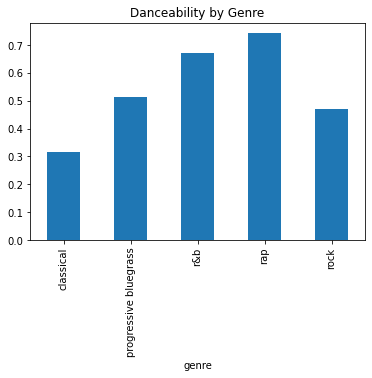

In [30]:
genre_mean['danceability'].plot(kind='bar');
plt.title('Danceability by Genre')

It looks like Rap has the highest danceability at over 0.7, Classical has the lowest danceability at just above 0.3.

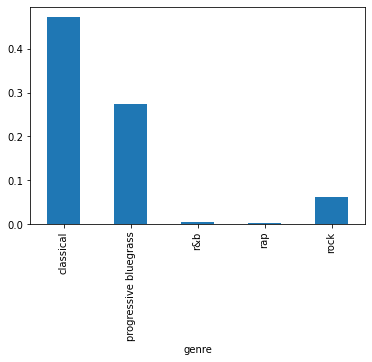

In [31]:
genre_mean['instrumentalness'].plot(kind='bar');

Classical has the highest instrumentalness, while rap has the lowest

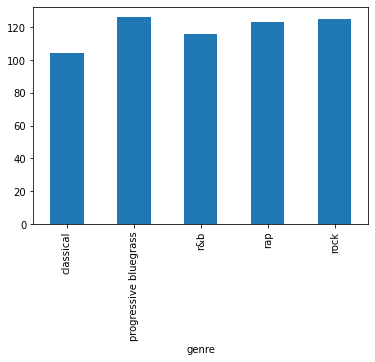

In [32]:
genre_mean['tempo'].plot(kind='bar');

Interesting that most of the genres hover slightly above 120 as a tempo. There's some interesting reasoning behind this with commercial music and the need for 30-seconds of music to fill an advertising slot. 128 beats per minute would allow for a 16-bar phrase in 4/4 time.

In [33]:
X = songs._get_numeric_data().drop(columns=['key', 'mode'])
# Thanks joris on SO: https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe/32011969
y_cat = songs['genre'].astype('category').cat.codes

In [34]:
y = to_categorical(y_cat)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)

In [36]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [ ]:
fnn_model = Sequential()

fnn_model.add(Dense(9, activation='relu', input_shape=(X_train_sc.shape[1],)))
fnn_model.add(Dense(32, activation='relu'))
fnn_model.add(Dropout(0.2))
fnn_model.add(Dense(16, activation='relu'))
fnn_model.add(Dense(5, activation='softmax'))

fnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

hist = fnn_model.fit(X_train_sc, y_train,
                epochs=500,
                batch_size=128,
                validation_data=(X_test_sc, y_test),
                    use_multiprocessing=True,
                    verbose=0)

In [ ]:
plt.plot(hist.history['acc'], label="Training Acc")
plt.plot(hist.history['val_acc'], label="Testing Acc")
plt.legend();

I don't seem to be able to get higher than **77% accuracy** with the features Spotify provides, even with a Feedforward Neural Network

## What's next?

Now that I've seen how accurate models can be with the features that Spotify provides, I want to create/extract my own features from the audio I've pulled from Spotify.